# Grass cover compared to baseline - December

- Weighted means take into account the number of days in each month

In [1]:
# import libraries
import glob
import importlib
import itertools
import os
import sys
from datetime import datetime, timezone
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import climag.plot_configs as cplt
import climag.plot_stats as cstats

In [2]:
exp_list = ["historical", "rcp45", "rcp85"]
model_list = ["CNRM-CM5", "EC-EARTH", "HadGEM2-ES", "MPI-ESM-LR"]
dataset_list = ["EURO-CORDEX", "HiResIreland"]

In [3]:
importlib.reload(cstats)

<module 'climag.plot_stats' from '/run/media/nms/Backup/Documents/Git/ClimAg/ClimAg/climag/plot_stats.py'>

In [4]:
def keep_minimal_vars(data):
    """
    Drop variables that are not needed
    """

    data = data.drop_vars([
        "bm_gv", "bm_gr", "bm_dv", "bm_dr", "age_gv", "age_gr", "age_dv",
        "age_dr", "omd_gv", "omd_gr", "lai", "env", "wr", "aet",
        "sen_gv", "sen_gr", "abs_dv", "abs_dr", "i_bm", "h_bm",
        "pgro", "c_bm", "gro"
    ])

    return data

In [5]:
def combine_datasets(dataset_dict, dataset_crs):
    dataset = xr.combine_by_coords(
        dataset_dict.values(), combine_attrs="override"
    )
    dataset.rio.write_crs(dataset_crs, inplace=True)

    return dataset

In [6]:
def mean_wgt(ds, months):
    ds_m = ds.sel(time=ds["time"].dt.month.isin(months))

    weights = (
        ds_m["time"].dt.days_in_month.groupby("time.year") /
        ds_m["time"].dt.days_in_month.groupby("time.year").sum()
    )

    # test that the sum of weights for each season is one
    np.testing.assert_allclose(
        weights.groupby("time.year").sum().values,
        np.ones(len(set(weights["year"].values)))
    )

    # calculate the weighted average
    ds_m = (ds_m * weights).groupby("time.year").sum(dim="time")

    return ds_m

In [7]:
def reduce_dataset(dataset):
    ds = {}
    ds_son = {}
    # ds_mam = {}
    # ds_jja = {}

    for exp, model in itertools.product(exp_list, model_list):
        # auto-rechunking may cause NotImplementedError with object dtype
        # where it will not be able to estimate the size in bytes of object
        # data
        if model == "HadGEM2-ES":
            CHUNKS = 300
        else:
            CHUNKS = "auto"

        ds[f"{model}_{exp}"] = xr.open_mfdataset(
            glob.glob(
                os.path.join(
                    "data", "ModVege", dataset, exp, model,
                    f"*{dataset}*{model}*{exp}*.nc"
                )
            ),
            chunks=CHUNKS,
            decode_coords="all"
        )

        # copy CRS
        crs_ds = ds[f"{model}_{exp}"].rio.crs

        # remove spin-up year
        if exp == "historical":
            ds[f"{model}_{exp}"] = ds[f"{model}_{exp}"].sel(
                time=slice("1976", "2005")
            )
        else:
            ds[f"{model}_{exp}"] = ds[f"{model}_{exp}"].sel(
                time=slice("2041", "2070")
            )

        # convert HadGEM2-ES data back to 360-day calendar
        # this ensures that the correct weighting is applied when
        # calculating the weighted average
        if model == "HadGEM2-ES":
            ds[f"{model}_{exp}"] = ds[f"{model}_{exp}"].convert_calendar(
                "360_day", align_on="year"
            )

        # assign new coordinates and dimensions
        ds[f"{model}_{exp}"] = ds[f"{model}_{exp}"].assign_coords(exp=exp)
        ds[f"{model}_{exp}"] = ds[f"{model}_{exp}"].expand_dims(dim="exp")
        ds[f"{model}_{exp}"] = ds[f"{model}_{exp}"].assign_coords(model=model)
        ds[f"{model}_{exp}"] = ds[f"{model}_{exp}"].expand_dims(dim="model")

        # # calculate cumulative biomass
        # ds[f"{model}_{exp}"] = ds[f"{model}_{exp}"].assign(
        #     bm_t=(
        #         ds[f"{model}_{exp}"]["bm"] + ds[f"{model}_{exp}"]["i_bm"] +
        #         ds[f"{model}_{exp}"]["h_bm"]
        #     )
        # )

        # drop unnecessary variables
        ds[f"{model}_{exp}"] = keep_minimal_vars(data=ds[f"{model}_{exp}"])

        # weighted mean - yearly, Dec
        ds_son[f"{model}_{exp}"] = mean_wgt(ds[f"{model}_{exp}"], [12])

    # combine data
    # ds = combine_datasets(ds, crs_ds)
    ds_son = combine_datasets(ds_son, crs_ds)
    # ds_mam = combine_datasets(ds_mam, crs_ds)
    # ds_jja = combine_datasets(ds_jja, crs_ds)

    # ensemble mean
    ds_son = ds_son.mean(dim="model", skipna=True)
    # ds_mam = ds_mam.mean(dim="model", skipna=True)
    # ds_jja = ds_jja.mean(dim="model", skipna=True)

    # long-term average
    ds_son_lta = ds_son.mean(dim="year", skipna=True)

    # # shift SON year by one
    # ds_son["year"] = ds_son["year"] + 1

    return ds_son, ds_son_lta,  # ds_jja, ds_mam

In [8]:
# mask out non-pasture areas
mask_layer = gpd.read_file(
    os.path.join("data", "boundaries", "boundaries.gpkg"),
    layer="CLC_2018_MASK_PASTURE_2157_IE"
)

## EURO-CORDEX

In [40]:
ds_son, ds_son_lta = reduce_dataset("EURO-CORDEX")

### Anomalies in Dec farm cover compared to the historical LTA

In [17]:
plot_data = (
    ds_son.mean(dim="year", skipna=True) -
    ds_son_lta.sel(exp="historical").drop_vars("exp")
).sel(exp=["rcp45", "rcp85"]).assign_coords(
    dataset="EURO-CORDEX"
).expand_dims(dim="dataset")

In [18]:
# plot_data["exp"] = plot_data["exp"].where(
#     plot_data["exp"] != "rcp45", "rcp45 - historical"
# )

# plot_data["exp"] = plot_data["exp"].where(
#     plot_data["exp"] != "rcp85", "rcp85 - historical"
# )

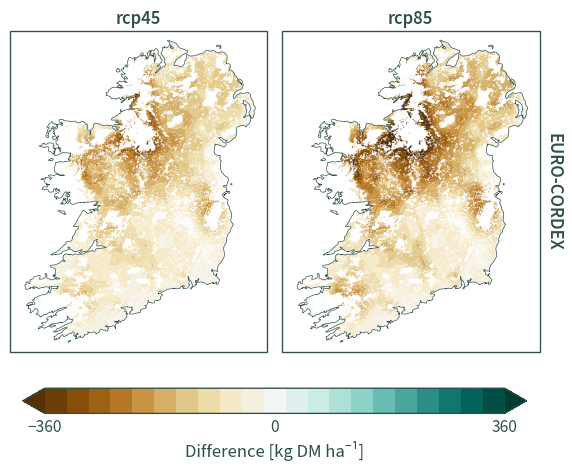

In [19]:
fig = plot_data["bm"].plot.contourf(
    x="rlon", y="rlat", col="exp", row="dataset",
    robust=True, extend="both", cmap="BrBG",
    subplot_kws={"projection": cplt.plot_projection},
    transform=cplt.rotated_pole_transform(plot_data),
    xlim=(-1.775, 1.6),
    ylim=(-2.1, 2.1),
    figsize=(6, 4.75),
    levels=cstats.colorbar_levels(360),
    cbar_kwargs={
        "label": "Difference [kg DM ha⁻¹]",
        "aspect": 20,
        "location": "bottom",
        "fraction": 0.085,
        "shrink": 0.95,
        "pad": 0.085,
        "extendfrac": "auto",
        "ticks": cstats.colorbar_ticks(360)
    }
)
for axis in fig.axs.flat:
    mask_layer.to_crs(cplt.plot_projection).plot(
        ax=axis, color="white", linewidth=0
    )
    cstats.ie_bbox.to_crs(cplt.plot_projection).plot(
        ax=axis, edgecolor="darkslategrey", color="white",
        linewidth=.5
    )
fig.set_titles("{value}", weight="semibold", fontsize=14)
plt.show()

### Actual farm cover

In [41]:
plot_data = ds_son.mean(dim="year", skipna=True).assign_coords(
    dataset="EURO-CORDEX"
).expand_dims(dim="dataset")

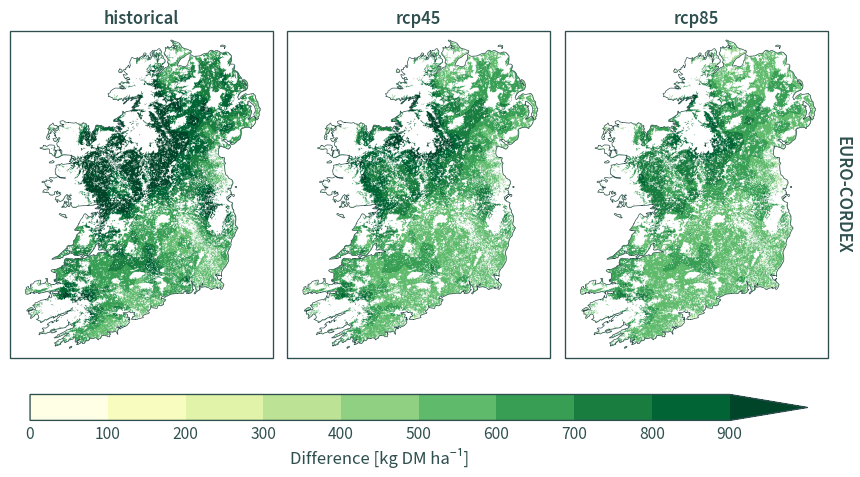

In [42]:
fig = plot_data["bm"].plot.contourf(
    x="rlon", y="rlat", col="exp", row="dataset",
    robust=True, extend="max", cmap="YlGn",
    subplot_kws={"projection": cplt.plot_projection},
    transform=cplt.rotated_pole_transform(plot_data),
    xlim=(-1.775, 1.6),
    ylim=(-2.1, 2.1),
    figsize=(9, 4.75),
    levels=[n * 100 for n in range(10)],
    cbar_kwargs={
        "label": "Difference [kg DM ha⁻¹]",
        "aspect": 30,
        "location": "bottom",
        "fraction": 0.085,
        "shrink": 0.95,
        "pad": 0.085,
        "extendfrac": "auto",
        # "ticks": cstats.colorbar_ticks(360)
    }
)
for axis in fig.axs.flat:
    mask_layer.to_crs(cplt.plot_projection).plot(
        ax=axis, color="white", linewidth=0
    )
    cstats.ie_bbox.to_crs(cplt.plot_projection).plot(
        ax=axis, edgecolor="darkslategrey", color="white",
        linewidth=.5
    )
fig.set_titles("{value}", weight="semibold", fontsize=14)
plt.show()

### Anomalies in Dec farm cover compared to the baseline

In [15]:
plot_data = (ds_son.mean(dim="year", skipna=True) - 550).assign_coords(
    dataset="EURO-CORDEX"
).expand_dims(dim="dataset")

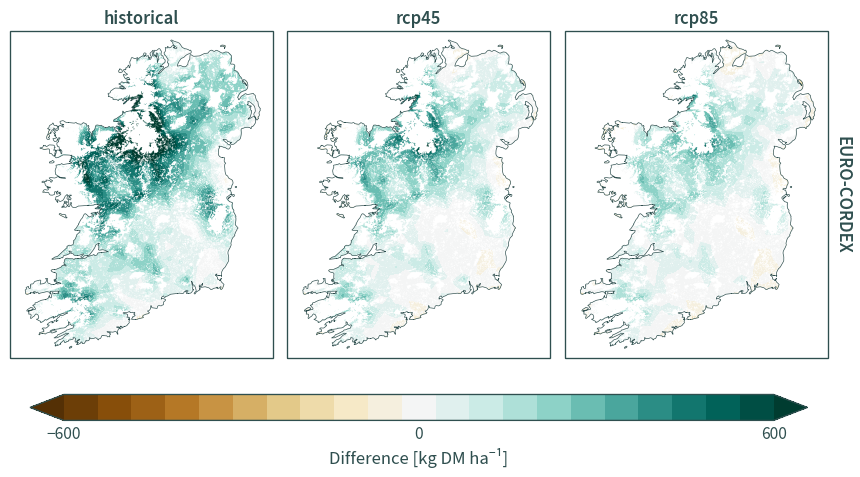

In [16]:
fig = plot_data["bm"].plot.contourf(
    x="rlon", y="rlat", col="exp", row="dataset",
    robust=True, extend="both", cmap="BrBG",
    subplot_kws={"projection": cplt.plot_projection},
    transform=cplt.rotated_pole_transform(plot_data),
    xlim=(-1.775, 1.6),
    ylim=(-2.1, 2.1),
    figsize=(9, 4.75),
    levels=cstats.colorbar_levels(600),
    cbar_kwargs={
        "label": "Difference [kg DM ha⁻¹]",
        "aspect": 30,
        "location": "bottom",
        "fraction": 0.085,
        "shrink": 0.95,
        "pad": 0.085,
        "extendfrac": "auto",
        "ticks": cstats.colorbar_ticks(600)
    }
)
for axis in fig.axs.flat:
    mask_layer.to_crs(cplt.plot_projection).plot(
        ax=axis, color="white", linewidth=0
    )
    cstats.ie_bbox.to_crs(cplt.plot_projection).plot(
        ax=axis, edgecolor="darkslategrey", color="white",
        linewidth=.5
    )
fig.set_titles("{value}", weight="semibold", fontsize=14)
plt.show()

## HiResIreland

In [32]:
ds_son, ds_son_lta = reduce_dataset("HiResIreland")

### Anomalies in Dec farm cover compared to the historical LTA

In [13]:
plot_data = (
    ds_son.mean(dim="year", skipna=True) -
    ds_son_lta.sel(exp="historical").drop_vars("exp")
).sel(exp=["rcp45", "rcp85"]).assign_coords(
    dataset="HiResIreland"
).expand_dims(dim="dataset")

In [15]:
# plot_data["exp"] = plot_data["exp"].where(
#     plot_data["exp"] != "rcp45", "rcp45 - historical"
# )

# plot_data["exp"] = plot_data["exp"].where(
#     plot_data["exp"] != "rcp85", "rcp85 - historical"
# )

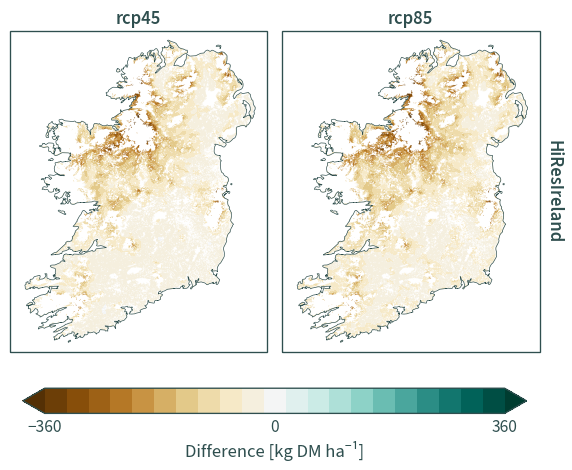

In [15]:
fig = plot_data["bm"].plot.contourf(
    x="rlon", y="rlat", col="exp", row="dataset",
    robust=True, extend="both", cmap="BrBG",
    subplot_kws={"projection": cplt.plot_projection},
    transform=cplt.rotated_pole_transform(plot_data),
    xlim=(-1.775, 1.6),
    ylim=(-2.1, 2.1),
    figsize=(6, 4.75),
    levels=cstats.colorbar_levels(360),
    cbar_kwargs={
        "label": "Difference [kg DM ha⁻¹]",
        "aspect": 20,
        "location": "bottom",
        "fraction": 0.085,
        "shrink": 0.95,
        "pad": 0.085,
        "extendfrac": "auto",
        "ticks": cstats.colorbar_ticks(360)
    }
)
for axis in fig.axs.flat:
    mask_layer.to_crs(cplt.plot_projection).plot(
        ax=axis, color="white", linewidth=0
    )
    cstats.ie_bbox.to_crs(cplt.plot_projection).plot(
        ax=axis, edgecolor="darkslategrey", color="white",
        linewidth=.5
    )
fig.set_titles("{value}", weight="semibold", fontsize=14)
plt.show()

### Actual farm cover

In [33]:
plot_data = ds_son.mean(dim="year", skipna=True).assign_coords(
    dataset="HiResIreland"
).expand_dims(dim="dataset")

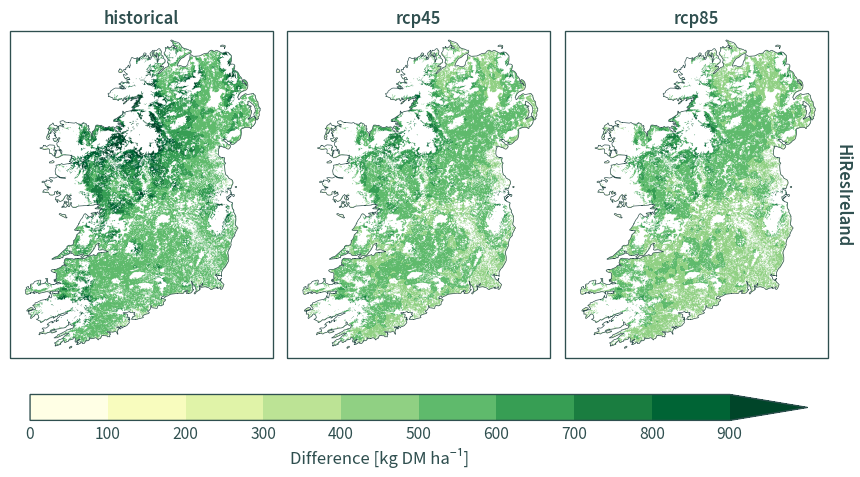

In [39]:
fig = plot_data["bm"].plot.contourf(
    x="rlon", y="rlat", col="exp", row="dataset",
    robust=True, extend="max", cmap="YlGn",
    subplot_kws={"projection": cplt.plot_projection},
    transform=cplt.rotated_pole_transform(plot_data),
    xlim=(-1.775, 1.6),
    ylim=(-2.1, 2.1),
    figsize=(9, 4.75),
    levels=[n * 100 for n in range(10)],
    cbar_kwargs={
        "label": "Difference [kg DM ha⁻¹]",
        "aspect": 30,
        "location": "bottom",
        "fraction": 0.085,
        "shrink": 0.95,
        "pad": 0.085,
        "extendfrac": "auto",
        # "ticks": cstats.colorbar_ticks(360)
    }
)
for axis in fig.axs.flat:
    mask_layer.to_crs(cplt.plot_projection).plot(
        ax=axis, color="white", linewidth=0
    )
    cstats.ie_bbox.to_crs(cplt.plot_projection).plot(
        ax=axis, edgecolor="darkslategrey", color="white",
        linewidth=.5
    )
fig.set_titles("{value}", weight="semibold", fontsize=14)
plt.show()

### Anomalies in Dec farm cover compared to the baseline

In [22]:
plot_data = (ds_son.mean(dim="year", skipna=True) - 550).assign_coords(
    dataset="HiResIreland"
).expand_dims(dim="dataset")

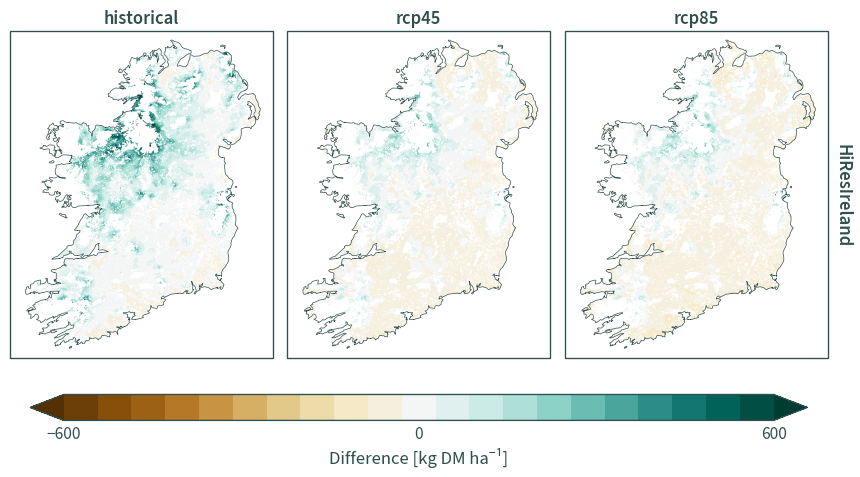

In [23]:
fig = plot_data["bm"].plot.contourf(
    x="rlon", y="rlat", col="exp", row="dataset",
    robust=True, extend="both", cmap="BrBG",
    subplot_kws={"projection": cplt.plot_projection},
    transform=cplt.rotated_pole_transform(plot_data),
    xlim=(-1.775, 1.6),
    ylim=(-2.1, 2.1),
    figsize=(9, 4.75),
    levels=cstats.colorbar_levels(600),
    cbar_kwargs={
        "label": "Difference [kg DM ha⁻¹]",
        "aspect": 30,
        "location": "bottom",
        "fraction": 0.085,
        "shrink": 0.95,
        "pad": 0.085,
        "extendfrac": "auto",
        "ticks": cstats.colorbar_ticks(600)
    }
)
for axis in fig.axs.flat:
    mask_layer.to_crs(cplt.plot_projection).plot(
        ax=axis, color="white", linewidth=0
    )
    cstats.ie_bbox.to_crs(cplt.plot_projection).plot(
        ax=axis, edgecolor="darkslategrey", color="white",
        linewidth=.5
    )
fig.set_titles("{value}", weight="semibold", fontsize=14)
plt.show()